<a href="https://colab.research.google.com/github/shahd1995913/Multi-Language-LLM-for-Plant-Leaf-Diseases/blob/main/Exp2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# =========================================
#1️⃣ Install the necessary libraries
# =========================================
!pip install torch torchvision torchaudio
!pip install timm
!pip install transformers
!pip install scikit-learn
!pip install matplotlib
!pip install pandas
!pip install transformers accelerate sentencepiece
!pip install transformers accelerate sentencepiece
! pip install grad-cam

In [3]:
# =========================================
# 1️⃣ Imports
# =========================================
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
import os
import shutil

from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Now your Google Drive files are accessible under /content/drive/MyDrive/

# =========================================
# 2️⃣ Setup Dataset
# =========================================
# Copy dataset to local tmp for speed
src_dir = "/content/drive/MyDrive/PALM Reserch/Palm Leaves Dataset"
data_dir = "/tmp/palm_dataset"
if not os.path.exists(data_dir):
    shutil.copytree(src_dir, data_dir)

# Filter out empty folders
valid_folders = [f for f in os.listdir(data_dir)
                 if os.path.isdir(os.path.join(data_dir,f))
                 and len(os.listdir(os.path.join(data_dir,f))) > 0]

# Image transforms (smaller size = faster)
transform = transforms.Compose([
    transforms.Resize((96,96)),  # smaller than 128x128 for speed
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

# Load dataset
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
classes = dataset.classes
print("✅ Classes Detected:", classes)

# =========================================
# 3️⃣ Split dataset 70/20/10
# =========================================
total_len = len(dataset)
train_len = int(0.7 * total_len)
val_len = int(0.2 * total_len)
test_len = total_len - train_len - val_len

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_len, val_len, test_len])

# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
# val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)


print(f"Total images: {total_len} | Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")

# =========================================
# 4️⃣ Plot sample image from each class
# =========================================
# def imshow(img, title):
#     img = img.numpy().transpose((1,2,0))
#     img = img * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406])
#     img = np.clip(img, 0,1)
#     plt.imshow(img)
#     plt.title(title)
#     plt.axis('off')
#     plt.show()

# for i, cls in enumerate(classes):
#     idx = next(idx for idx, (_, label) in enumerate(dataset.samples) if label == i)
#     img, _ = dataset[idx]
#     imshow(img, cls)

# =========================================
# 5️⃣ Setup MobileNetV3 small
# =========================================
device = "cuda" if torch.cuda.is_available() else "cpu"
model = models.mobilenet_v3_small(pretrained=True)
model.classifier[3] = nn.Linear(model.classifier[3].in_features, len(classes))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# =========================================
# 6️⃣ Train function
# =========================================
def train_model(model, train_loader, val_loader, epochs=5):
    best_val_acc = 0
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        avg_train_loss = train_loss / len(train_loader)

        # Validation
        model.eval()
        val_preds, val_labels = [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                preds = torch.argmax(outputs, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
        val_acc = accuracy_score(val_labels, val_preds)
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Acc: {val_acc:.4f}")
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_model.pth")
    print("Training complete. Best Val Acc:", best_val_acc)

# =========================================
# 7️⃣ Train
# =========================================
train_model(model, train_loader, val_loader, epochs=5)

# =========================================
# 8️⃣ Evaluate on Test Set
# =========================================
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')
prec = precision_score(all_labels, all_preds, average='weighted')
rec = recall_score(all_labels, all_preds, average='weighted')
err_rate = 1 - acc
cm = confusion_matrix(all_labels, all_preds)

print("Accuracy:", acc)
print("F1 Score:", f1)
print("Precision:", prec)
print("Recall:", rec)
print("Error Rate:", err_rate)
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(all_labels, all_preds, target_names=classes))

Mounted at /content/drive
✅ Classes Detected: ['Bacterial leaf blight', 'Bug', 'Dubas', 'Healthy', 'Honey', 'brown spots', 'white scale']
Total images: 3848 | Train: 2693 | Val: 769 | Test: 386


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


100%|██████████| 9.83M/9.83M [00:00<00:00, 13.1MB/s]


Epoch 1/5 | Train Loss: 0.7116 | Val Acc: 0.6996
Epoch 2/5 | Train Loss: 0.2987 | Val Acc: 0.8205
Epoch 3/5 | Train Loss: 0.1923 | Val Acc: 0.8270
Epoch 4/5 | Train Loss: 0.1687 | Val Acc: 0.8492
Epoch 5/5 | Train Loss: 0.1460 | Val Acc: 0.8635
Training complete. Best Val Acc: 0.8634590377113134
Accuracy: 0.8704663212435233
F1 Score: 0.8676335993392781
Precision: 0.8718104867714808
Recall: 0.8704663212435233
Error Rate: 0.1295336787564767
Confusion Matrix:
 [[ 4  0  0  0  0  0  0]
 [ 0 57  1  6  1  0  0]
 [ 0 13 57  0 13  0  1]
 [ 0  0  0 86  0  0  0]
 [ 0  4  8  1 25  0  1]
 [ 0  1  0  0  0 23  0]
 [ 0  0  0  0  0  0 84]]

Classification Report:
                        precision    recall  f1-score   support

Bacterial leaf blight       1.00      1.00      1.00         4
                  Bug       0.76      0.88      0.81        65
                Dubas       0.86      0.68      0.76        84
              Healthy       0.92      1.00      0.96        86
                Honey       

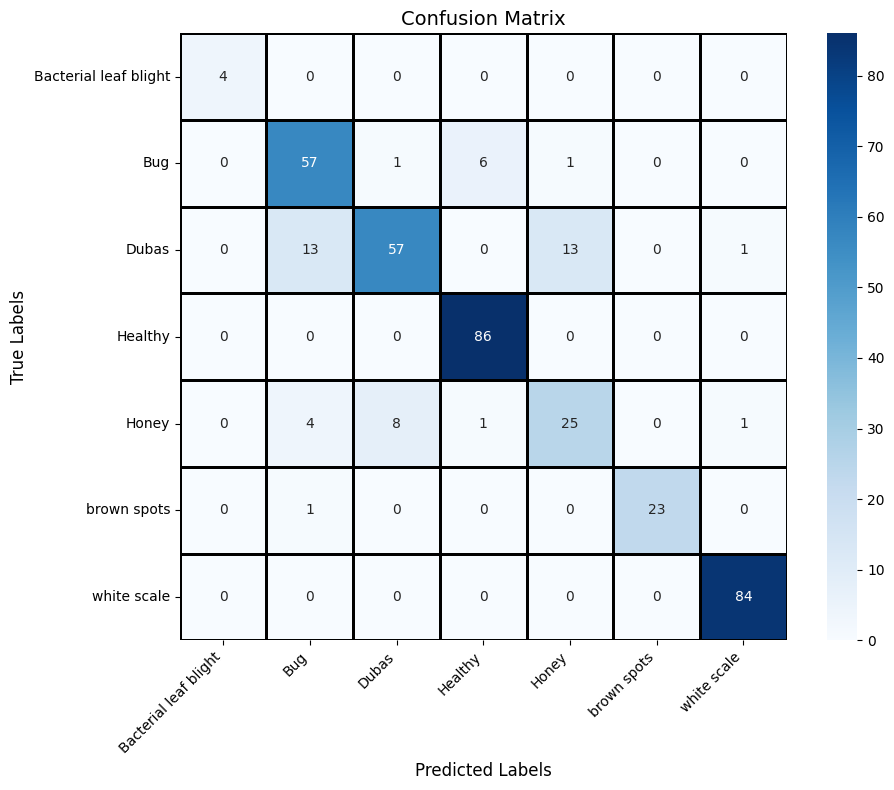

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Confusion matrix
cm = np.array([[ 4,  0,  0,  0,  0,  0,  0],
               [ 0, 57,  1,  6,  1,  0,  0],
               [ 0, 13, 57,  0, 13,  0,  1],
               [ 0,  0,  0, 86,  0,  0,  0],
               [ 0,  4,  8,  1, 25,  0,  1],
               [ 0,  1,  0,  0,  0, 23,  0],
               [ 0,  0,  0,  0,  0,  0, 84]])

classes = ['Bacterial leaf blight', 'Bug', 'Dubas', 'Healthy', 'Honey', 'brown spots', 'white scale']

plt.figure(figsize=(10,8))

# Academic-style heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=classes, yticklabels=classes,
            linewidths=0.8, linecolor='black', square=True)

plt.ylabel('True Labels', fontsize=12)
plt.xlabel('Predicted Labels', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"


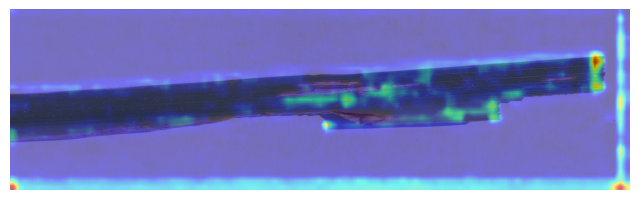

In [15]:
import torch
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1️⃣ إعداد الجهاز
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2️⃣ تحميل MobileNetV3
weights = MobileNet_V3_Small_Weights.DEFAULT
model = mobilenet_v3_small(weights=weights).to(device)
model.eval()

# 3️⃣ تحديد آخر طبقة Conv
target_layer = model.features[-1]

# 4️⃣ إنشاء GradCAM
cam = GradCAM(model=model, target_layers=[target_layer])

# 5️⃣ تحميل صورة نبات مريض
image_path = "/content/drive/MyDrive/PALM Reserch/Palm Leaves Dataset/Bacterial leaf blight/DSC_0365.JPG"  # غيّري للمسار الصحيح
rgb_img = cv2.imread(image_path, 1)[:, :, ::-1]  # BGR → RGB
rgb_img = np.float32(rgb_img) / 255.0

# 6️⃣ تجهيز الصورة
input_tensor = preprocess_image(rgb_img,
                                mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225]).to(device)

# 7️⃣ حساب Grad-CAM
grayscale_cam = cam(input_tensor=input_tensor, targets=None)[0, :]

# 8️⃣ دمج الخريطة مع الصورة الأصلية
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

# 9️⃣ عرض الصورة
plt.figure(figsize=(8, 8))
plt.imshow(visualization)
plt.axis("off")
plt.show()

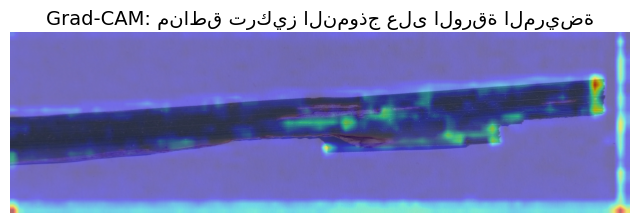

In [16]:
import torch
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import preprocess_image
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1️⃣ إعداد الجهاز
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2️⃣ تحميل MobileNetV3
weights = MobileNet_V3_Small_Weights.DEFAULT
model = mobilenet_v3_small(weights=weights).to(device)
model.eval()

# 3️⃣ تحديد آخر طبقة Conv
target_layer = model.features[-1]

# 4️⃣ إنشاء GradCAM
cam = GradCAM(model=model, target_layers=[target_layer])

# 5️⃣ تحميل صورة نبات مريض
image_path = "/content/drive/MyDrive/PALM Reserch/Palm Leaves Dataset/Bacterial leaf blight/DSC_0365.JPG"
rgb_img = cv2.imread(image_path, 1)[:, :, ::-1]  # BGR → RGB
rgb_img = np.float32(rgb_img) / 255.0

# 6️⃣ تجهيز الصورة
input_tensor = preprocess_image(rgb_img,
                                mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225]).to(device)

# 7️⃣ حساب Grad-CAM
grayscale_cam = cam(input_tensor=input_tensor, targets=None)[0, :]

# 8️⃣ رسم Heatmap أكاديمي مباشرة على الصورة الأصلية
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(rgb_img)  # الصورة الأصلية
ax.imshow(grayscale_cam, cmap='jet', alpha=0.5)  # Grad-CAM شفافة
ax.axis('off')
ax.set_title("Grad-CAM: مناطق تركيز النموذج على الورقة المريضة", fontsize=14)
plt.show()


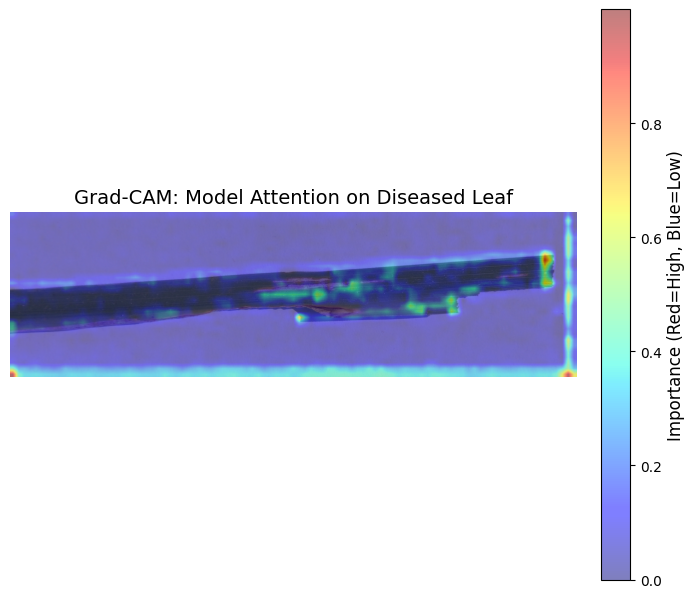

In [17]:
import torch
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import preprocess_image
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# 1️⃣ Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2️⃣ Load MobileNetV3
weights = MobileNet_V3_Small_Weights.DEFAULT
model = mobilenet_v3_small(weights=weights).to(device)
model.eval()

# 3️⃣ Select last convolutional layer
target_layer = model.features[-1]

# 4️⃣ Create GradCAM object
cam = GradCAM(model=model, target_layers=[target_layer])

# 5️⃣ Load a diseased plant image
image_path = "/content/drive/MyDrive/PALM Reserch/Palm Leaves Dataset/Bacterial leaf blight/DSC_0365.JPG"
rgb_img = cv2.imread(image_path, 1)[:, :, ::-1]  # BGR → RGB
rgb_img = np.float32(rgb_img) / 255.0

# 6️⃣ Preprocess the image
input_tensor = preprocess_image(
    rgb_img,
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
).to(device)

# 7️⃣ Compute Grad-CAM
grayscale_cam = cam(input_tensor=input_tensor, targets=None)[0, :]

# 8️⃣ Plot with academic-style explanation
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(rgb_img)  # Original image

# Overlay Grad-CAM
heatmap = ax.imshow(grayscale_cam, cmap='jet', alpha=0.5)

# Remove axes
ax.axis('off')
ax.set_title("Grad-CAM: Model Attention on Diseased Leaf", fontsize=14)

# Add colorbar to explain colors
cbar = fig.colorbar(heatmap, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Importance (Red=High, Blue=Low)', fontsize=12)
cbar.ax.tick_params(labelsize=10)

plt.show()


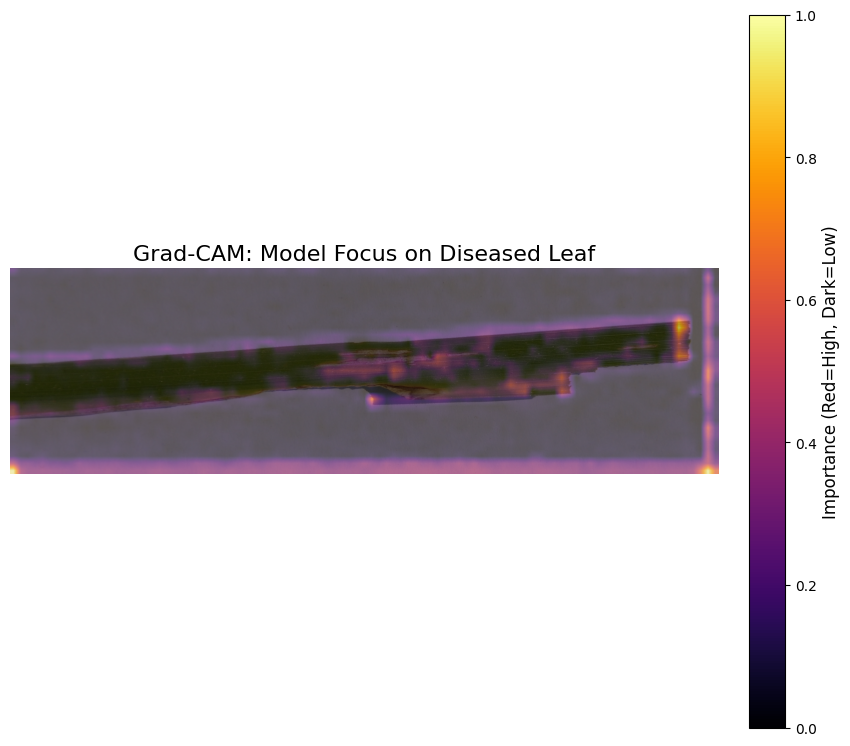

In [18]:
import torch
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import preprocess_image
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1️⃣ Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2️⃣ Load MobileNetV3
weights = MobileNet_V3_Small_Weights.DEFAULT
model = mobilenet_v3_small(weights=weights).to(device)
model.eval()

# 3️⃣ Select last convolutional layer
target_layer = model.features[-1]

# 4️⃣ Create GradCAM
cam = GradCAM(model=model, target_layers=[target_layer])

# 5️⃣ Load the image
image_path = "/content/drive/MyDrive/PALM Reserch/Palm Leaves Dataset/Bacterial leaf blight/DSC_0365.JPG"
rgb_img = cv2.imread(image_path, 1)[:, :, ::-1]  # BGR → RGB
rgb_img = np.float32(rgb_img) / 255.0

# 6️⃣ Preprocess the image
input_tensor = preprocess_image(
    rgb_img,
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
).to(device)

# 7️⃣ Compute Grad-CAM
grayscale_cam = cam(input_tensor=input_tensor, targets=None)[0, :]

# 8️⃣ Normalize Grad-CAM for better contrast
grayscale_cam = (grayscale_cam - grayscale_cam.min()) / (grayscale_cam.max() - grayscale_cam.min() + 1e-8)

# 9️⃣ Plot clear academic-style Grad-CAM
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(rgb_img)  # Original image
ax.imshow(grayscale_cam, cmap='inferno', alpha=0.6)  # stronger heatmap, clearer
ax.axis('off')
ax.set_title("Grad-CAM: Model Focus on Diseased Leaf", fontsize=16)

# Colorbar to explain importance
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap='inferno'), ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Importance (Red=High, Dark=Low)', fontsize=12)
cbar.ax.tick_params(labelsize=10)

plt.show()